## Final Project on Introduction to marketing analytics
### Deep Learning recommendation system 
##### By Gordonov Nikita, Ishmuratov Sergey, Kaminskiy Dmitriy, Karasev Dmitriy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import itertools as it
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score

In [2]:
user_recipe_full = pd.read_csv('fe_user_recipe_matrix.csv')
user_recipe_train = pd.read_csv('user_recipe_matrix_train_only.csv')
recipe_ingr = pd.read_csv('fe_recipe_attribute_matrix_file84.csv')

user_recipe_train.replace(2, np.nan, inplace=True)

In [3]:
# Data preprocessing 

df_melted = pd.melt(user_recipe_full, 'user_id').rename(columns = {'variable' : 'recipe', 'value' : 'liked'})
df_melted

,user_id,recipe,liked
0,10000716:0,slow-cooker-pot-roast:295,0
1,10002095:1,slow-cooker-pot-roast:295,0
2,10004231:2,slow-cooker-pot-roast:295,1
3,10009015:3,slow-cooker-pot-roast:295,1
4,10014110:4,slow-cooker-pot-roast:295,0
...,...,...,...
999995,19941788:995,baked-chicken-2:470,1
999996,1994436:996,baked-chicken-2:470,0
999997,19947462:997,baked-chicken-2:470,1
999998,19947669:998,baked-chicken-2:470,0


In [4]:
user_id_mapping = {id:i for i, id in enumerate(df_melted['user_id'].unique())}
recipe_id_mapping = {id:i for i, id in enumerate(df_melted['recipe'].unique())}
user_recipe_train['user_id'] = user_recipe_full['user_id']
df_train_melted = pd.melt(user_recipe_train, 'user_id').rename(columns = {'variable' : 'recipe', 'value' : 'liked'})
df_test = df_train_melted[df_train_melted['liked'].isna()]
df_test['liked'] = df_melted[df_train_melted['liked'].isna()]['liked']
df_train = df_train_melted[(df_train_melted['liked'].isna() == False)]
df_train

,user_id,recipe,liked
0,10000716:0,slow-cooker-pot-roast:295,0.0
1,10002095:1,slow-cooker-pot-roast:295,0.0
2,10004231:2,slow-cooker-pot-roast:295,1.0
3,10009015:3,slow-cooker-pot-roast:295,1.0
4,10014110:4,slow-cooker-pot-roast:295,0.0
...,...,...,...
999995,19941788:995,baked-chicken-2:470,1.0
999996,1994436:996,baked-chicken-2:470,0.0
999997,19947462:997,baked-chicken-2:470,1.0
999998,19947669:998,baked-chicken-2:470,0.0


In [5]:
train_user_data = df_train['user_id'].map(user_id_mapping)
train_recipe_data = df_train['recipe'].map(recipe_id_mapping)

test_user_data = df_test['user_id'].map(user_id_mapping)
test_recipe_data = df_test['recipe'].map(recipe_id_mapping)

In [6]:
# Searching for the best hyperparameters of the model

n_users = len(user_id_mapping)
n_recipes = len(recipe_id_mapping)
embedding_size = 10

ues = [15, 20, 25]
res = [15, 20, 25]
den = [128, 256]
for u in ues:
  for r in res:
    for d in den:
      # Setup variables
      user_embedding_size = u
      recipe_embedding_size = r


      ##### Create model
      # Set input layers
      user_id_input = Input(shape=[1], name='user')
      recipe_id_input = Input(shape=[1], name='recipe')

      # Create embedding layers for users and movies
      user_embedding = Embedding(output_dim=user_embedding_size, 
                                input_dim=n_users,
                                input_length=1, 
                                name='user_embedding')(user_id_input)
      recipe_embedding = Embedding(output_dim=recipe_embedding_size, 
                                  input_dim=n_recipes,
                                  input_length=1, 
                                  name='item_embedding')(recipe_id_input)

      # Reshape the embedding layers
      user_vector = Reshape([user_embedding_size])(user_embedding)
      recipe_vector = Reshape([recipe_embedding_size])(recipe_embedding)

      # Concatenate the reshaped embedding layers
      concat = Concatenate()([user_vector, recipe_vector])

      # Combine with dense layers
      dense = Dense(d, activation = 'relu')(concat)
      y = Dense(1)(dense)

      # Setup model
      model = Model(inputs=[user_id_input, recipe_id_input], outputs=y)
      model.compile(loss='mse', optimizer='adam')


      # Fit model
      model.fit([train_user_data, train_recipe_data],
                df_train['liked'],
                batch_size=256, 
                epochs=3,
                validation_split=0.1,
                shuffle=True)

      # Test model
      y_pred = model.predict([test_user_data, test_recipe_data])
      y_true = df_test['liked'].values
      print(u, r, d)


Epoch 1/3
3165/3165 [==============================] - 3s 872us/step - loss: 0.0975 - val_loss: 0.0986
Epoch 2/3
3165/3165 [==============================] - 3s 834us/step - loss: 0.0955 - val_loss: 0.0995
Epoch 3/3
3125/3125 [==============================] - 2s 475us/step
15 15 128
Epoch 1/3
3165/3165 [==============================] - 3s 924us/step - loss: 0.0975 - val_loss: 0.0976
Epoch 2/3
3165/3165 [==============================] - 3s 915us/step - loss: 0.0959 - val_loss: 0.0987
Epoch 3/3
3125/3125 [==============================] - 1s 466us/step
15 15 256
Epoch 1/3
3165/3165 [==============================] - 3s 902us/step - loss: 0.0975 - val_loss: 0.0975
Epoch 2/3
3165/3165 [==============================] - 3s 863us/step - loss: 0.0952 - val_loss: 0.1003
Epoch 3/3
3125/3125 [==============================] - 1s 465us/step
15 20 128
Epoch 1/3
3165/3165 [==============================] - 3s 962us/step - loss: 0.0975 - val_loss: 0.0984
Epoch 2/3
3165/3165 [=====================

In [7]:
def print_metrics(y_pred, y_true):
  preds = [int(i[0]) for i in y_pred > 0.5]
  acs = accuracy_score(preds, y_true)
  prec = precision_score(preds, y_true)
  rec = recall_score(preds, y_true)
  f1 = f1_score(preds, y_true)
  mse = mean_squared_error(preds, y_true)
  rmse = np.sqrt(mean_squared_error(preds, y_true))
  print('Accuracy:', acs)
  print('Precision:', prec)
  print('Recall:', rec)
  print('F1:', f1)
  print('MSE:', mse)
  print('RMSE:', rmse)

In [8]:
### BEST MODEL

# Setup variables
user_embedding_size = 15
recipe_embedding_size = 25


##### Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
recipe_id_input = Input(shape=[1], name='recipe')

# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=user_embedding_size, 
                          input_dim=n_users,
                          input_length=1, 
                          name='user_embedding')(user_id_input)
recipe_embedding = Embedding(output_dim=recipe_embedding_size, 
                            input_dim=n_recipes,
                            input_length=1, 
                            name='item_embedding')(recipe_id_input)

# Reshape the embedding layers
user_vector = Reshape([user_embedding_size])(user_embedding)
recipe_vector = Reshape([recipe_embedding_size])(recipe_embedding)

# Concatenate the reshaped embedding layers
concat = Concatenate()([user_vector, recipe_vector])

# Combine with dense layers
dense = Dense(128, activation = 'relu')(concat)
y = Dense(1)(dense)

# Setup model
model = Model(inputs=[user_id_input, recipe_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')


# Fit model
model.fit([train_user_data, train_recipe_data],
          df_train['liked'],
          batch_size = 256, 
          epochs=20,
          validation_split=0.1,
          shuffle=True)

# Test model
y_pred = model.predict([test_user_data, test_recipe_data])
y_true = df_test['liked'].values

print('\n')
print_metrics(y_pred, y_true)

Epoch 1/20
3165/3165 [==============================] - 4s 1ms/step - loss: 0.0975 - val_loss: 0.0989
Epoch 2/20
3165/3165 [==============================] - 3s 966us/step - loss: 0.0950 - val_loss: 0.0999
Epoch 3/20
3165/3165 [==============================] - 3s 965us/step - loss: 0.0927 - val_loss: 0.1025
Epoch 4/20
3165/3165 [==============================] - 3s 970us/step - loss: 0.0910 - val_loss: 0.1023
Epoch 5/20
3165/3165 [==============================] - 3s 983us/step - loss: 0.0898 - val_loss: 0.1049
Epoch 6/20
3165/3165 [==============================] - 3s 968us/step - loss: 0.0889 - val_loss: 0.1068
Epoch 7/20
3165/3165 [==============================] - 3s 981us/step - loss: 0.0881 - val_loss: 0.1064
Epoch 8/20
3165/3165 [==============================] - 3s 980us/step - loss: 0.0873 - val_loss: 0.1086
Epoch 9/20
3165/3165 [==============================] - 3s 972us/step - loss: 0.0867 - val_loss: 0.1069
Epoch 10/20
3165/3165 [==============================] - 3s 984us/

In [9]:
print(model.summary())

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 recipe (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 15)        15000       ['user[0][0]']                   
                                                                                                  
 item_embedding (Embedding)     (None, 1, 25)        25000       ['recipe[0][0]']                 
                                                                                           

In [10]:
# Dataframe for validation of the model

y_pred = np.resize(y_pred,(1, 100000))
y_pred = list(y_pred)[0]
df_pred = pd.concat([pd.concat([test_user_data ,test_recipe_data], axis=1).reset_index().drop('index',axis=1), pd.Series(y_pred), pd.Series(y_true)], axis=1)
df_pred.rename(columns={0: 'proba', 1: 'y_true'}, inplace=True)
df_pred['y_pred_label'] = (df_pred['proba']>0.5)*1
df_pred

,user_id,recipe,proba,y_true,y_pred_label
0,8,0,0.083687,0,0
1,31,0,0.188804,0,0
2,59,0,0.184925,1,0
3,63,0,0.079676,0,0
4,64,0,0.052207,0,0
...,...,...,...,...,...
99995,955,999,0.244059,0,0
99996,966,999,0.316021,0,0
99997,983,999,0.124917,0,0
99998,987,999,0.299933,0,0


In [11]:
# Example of recommendation for the concrete user

top_N = 10
df_pred[df_pred['user_id']==10].sort_values(by='proba', ascending=False)[:top_N]

,user_id,recipe,proba,y_true,y_pred_label
79069,10,791,0.589682,0,1
38464,10,385,0.541990,0,1
52773,10,527,0.479770,0,0
56059,10,560,0.421929,1,0
55367,10,553,0.413364,1,0
47398,10,474,0.392770,0,0
2099,10,21,0.378971,1,0
35572,10,356,0.377886,0,0
9029,10,92,0.374160,0,0
61481,10,614,0.367023,0,0


In [12]:
# Function for counting metrics

def get_metrics_nn(df_pred, top_N):
    
    mae = np.array([])
    rmse = np.array([])
    TP, FP, FN, TN = 0, 0, 0, 0

    for user in range(1000):
        recommendations = df_pred[df_pred['user_id']==user].sort_values(by='proba', ascending=False)[:top_N]
        for n in range(recommendations.shape[0]):
            mae = np.append(mae, np.abs(recommendations.iloc[n]['y_true'] - recommendations.iloc[n]['y_pred_label']))
            rmse = np.append(rmse, (recommendations.iloc[n]['y_true'] - recommendations.iloc[n]['y_pred_label'])**2)

            if recommendations.iloc[n]['y_true']==1 and recommendations.iloc[n]['y_pred_label'] == 1:
                TP += 1
            if recommendations.iloc[n]['y_true']==0 and recommendations.iloc[n]['y_pred_label'] == 1: 
                FP += 1
            if recommendations.iloc[n]['y_true']==1 and recommendations.iloc[n]['y_pred_label'] == 0: 
                FN += 1
            if recommendations.iloc[n]['y_true']==0 and recommendations.iloc[n]['y_pred_label'] == 0: 
                TN += 1
                
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * precision * recall / (precision + recall)   
    
    metrics = {'N': top_N, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall,
              'F1': F1, 'MAE': mae.mean(), 'RMSE': np.sqrt(rmse.mean())}
    
    return metrics

In [13]:
Ns = [1, 3, 5, 10, 20, 50, 70, 100]
nn_metrics = np.array([get_metrics_nn(df_pred, Ns[j]) for j in range(len(Ns))])

In [14]:
# Metrics for the same top_N for Logistic Regression (our baseline)
# Logistic Regression showed the best performance in HW4

logit_metrics = np.array([{'N': 1, 'Accuracy': 0.767, 'Precision': 0.1069182389937107, 'Recall': 0.1574074074074074, 'F1': 0.12734082397003746, 'MAE': 0.233, 'RMSE': 0.4827007354458868},{'N': 3, 'Accuracy': 0.8466666666666667, 'Precision': 0.11242603550295859, 'Recall': 0.057750759878419454, 'F1': 0.07630522088353414, 'MAE': 0.15333333333333332, 'RMSE': 0.39157800414902433},{'N': 5, 'Accuracy': 0.8596, 'Precision': 0.11242603550295859, 'Recall': 0.03327495621716287, 'F1': 0.051351351351351354, 'MAE': 0.1404, 'RMSE': 0.3746998799039039},{'N': 10, 'Accuracy': 0.8716, 'Precision': 0.11242603550295859, 'Recall': 0.01647875108412836, 'F1': 0.028744326777609682, 'MAE': 0.1284, 'RMSE': 0.35832945734337834},{'N': 20, 'Accuracy': 0.87275, 'Precision': 0.11242603550295859, 'Recall': 0.007870753935376968, 'F1': 0.014711575687185443, 'MAE': 0.12725, 'RMSE': 0.35672117963473937},{'N': 50, 'Accuracy': 0.88254, 'Precision': 0.11242603550295859, 'Recall': 0.0033089515848136537, 'F1': 0.006428692268651666, 'MAE': 0.11746, 'RMSE': 0.34272437905699094},{'N': 70, 'Accuracy': 0.881, 'Precision': 0.11242603550295859, 'Recall': 0.002317355775094524, 'F1': 0.004541108986615678, 'MAE': 0.119, 'RMSE': 0.3449637662132068},{'N': 100, 'Accuracy': 0.88179, 'Precision': 0.11242603550295859, 'Recall': 0.0016253207869974338, 'F1': 0.003204317396070495, 'MAE': 0.11821, 'RMSE': 0.34381681168901557}],dtype=object)

In [15]:
def plot_nn_versus_logit_metrics(nn_metrics, logit_metrics, Ns):
    names = ['N', 'Accuracy', 'Precision', 'Recall', 'F1', 'MAE', 'RMSE']

    n = [nn_metrics[i]['N'] for i in range(len(Ns))]
    accuracy = [nn_metrics[i]['Accuracy'] for i in range(len(Ns))]
    precision = [nn_metrics[i]['Precision'] for i in range(len(Ns))]
    recall = [nn_metrics[i]['Recall'] for i in range(len(Ns))]
    f1 = [nn_metrics[i]['F1'] for i in range(len(Ns))]
    mae = [nn_metrics[i]['MAE'] for i in range(len(Ns))]
    rmse = [nn_metrics[i]['RMSE'] for i in range(len(Ns))]
    help_list = [n, accuracy, precision, recall, f1, mae, rmse]
    
    accuracy_1 = [logit_metrics[i]['Accuracy'] for i in range(len(Ns))]
    precision_1 = [logit_metrics[i]['Precision'] for i in range(len(Ns))]
    recall_1 = [logit_metrics[i]['Recall'] for i in range(len(Ns))]
    f1_1 = [logit_metrics[i]['F1'] for i in range(len(Ns))]
    mae_1 = [logit_metrics[i]['MAE'] for i in range(len(Ns))]
    rmse_1 = [logit_metrics[i]['RMSE'] for i in range(len(Ns))]
    help_list_1 = [n, accuracy_1, precision_1, recall_1, f1_1, mae_1, rmse_1]
    
    

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))


    for i in range(3):
        ax = axes[0, i]
        ax.plot(help_list[0], help_list[i+1], c='red', label='nn')
        ax.plot(help_list_1[0], help_list_1[i+1], label ='logit')
        ax.set_xlabel("top_N")
        ax.legend(fontsize=13)
        ax.set_ylabel(names[i+1], fontsize=18)
    for i in range(3, 6):
        ax = axes[1, i-3]
        ax.plot(help_list[0], help_list[i+1], c='red', label='nn')
        ax.plot(help_list_1[0], help_list_1[i+1], label ='logit')
        ax.set_xlabel("top_N")
        ax.legend(fontsize=13)
        ax.set_ylabel(names[i+1], fontsize=18)

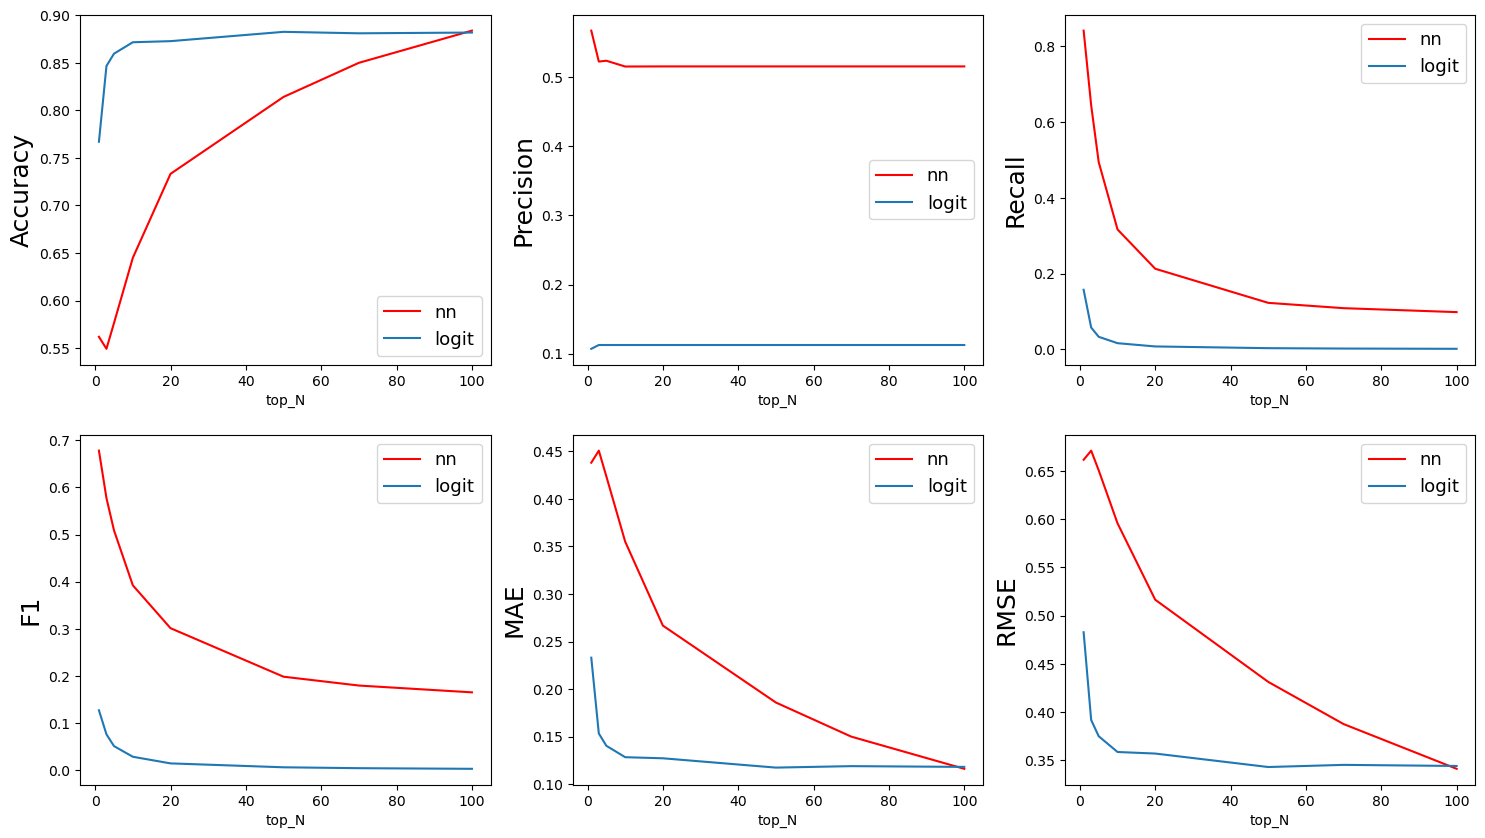

In [16]:
plot_nn_versus_logit_metrics(nn_metrics, logit_metrics, Ns)